# Hunting for Short Squeeze

### by Richard Kim & Shumiao Ouyang

### CSCI E-109 Data Science

In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import sklearn.decomposition

from pymongo import MongoClient

## Introduction

In [2]:
volkswagen = pd.read_csv('data/volkswagen.csv', index_col='date')
volkswagen.index = [pd.to_datetime(date[:10])  for date in volkswagen.index]

In October 2008, Volkswagen AG, the German automanufacturer, briefly became the most valuable company in the world as its share price jumped from $€209.63$ on October 24th 2008 to $€939.53$ on October 28th 2008, which was over 4 fold jump in the share price within 2 trading days.  This rare phenomenon was attributed as a result of "Short Squeeze."     

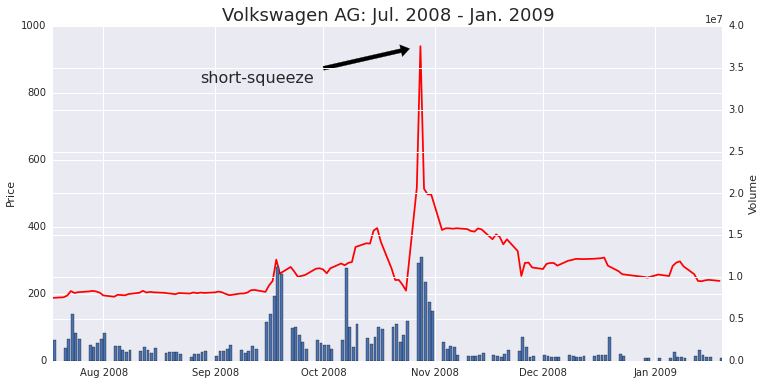

In [3]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(volkswagen.index, volkswagen['price'], color='r')
plt.ylim(0,1000)
plt.ylabel('Price')
plt.annotate('short-squeeze', xy=('2008-10-28', 939.528), xytext=('2008-08-28',830.528),
            arrowprops=dict(facecolor='black', shrink=0.1),fontsize='16')

ax2 = ax1.twinx()
ax2.bar(volkswagen.index, volkswagen['volume'])
plt.ylim(0,40000000)
plt.ylabel('Volume')

plt.title('Volkswagen AG: Jul. 2008 - Jan. 2009', fontsize='18')
plt.show()

#### What is Short Squeeze?

Before we discuss the definition of Short Squeeze, we have to begin by defining short sale of stock - for those who may not be familiar with technical details of stock investments.  

Short sale is an investment/trading method in which an investor borrows shares of the interested stock from a broker and sells it back in the market.  Typically, investors will short sell a stock if they have a pessimistic outlook on the underlying company.  For example, he or she may believe that earnings (or sales, operating cash flow, etc) of the company will substantially decline.  Other reasons may include - for a pharmaceutical company, rejection of a drug by FDA; for a defense company, loss of government contract, etc.  

Short sale strategy is to sell the stock when it is high and buy it back when it is low.  Thus, the strategy is the opposite of the common and widely known investment strategy - "buy low, and sell high."  Short sale strategy can be described as "sell high, and buy low."  It is an investment strategy often utilized by hedge funds and sophisticated individual investors.     

When a sufficiently large number of investors short sales a stock, this stock has a potential to experience Short Squeeze when these short investors in a relatively close period of time attempt to cover (buy back) their short sale position.  In such an instance, the stock price may jump rapidly, often over 5% up to 30% ~ 50% in a day.  As shown above in the example of Volkswagen in 2008, stock price may jump 400% in over 2 day period.  

For additional information about Short Squeeze please take a look at the link below:

http://wiki.fool.com/Short_squeeze

For additional information about Volkswagen share price in October 2008, please take a look at the link below:

http://www.reuters.com/article/2008/10/28/us-volkswagen-idUSTRE49R3I920081028

#### Motivation

One of our teammates, Richard Kim, CFA, had worked as an equity research analyst and investment banking analyst for approximately 6 years.  During his tenure as an analyst, he has personally seen numerous short squeeze phenomenons in the market; moreover, as a part of his duty as an analyst, he had to seek out and predict these short squeeze opportunities in the market. Richard analyzed trends in the historical financial statements, other analysts' estimates, short interest data, etc. and applied human intuition, experience, and know-how to predict the short squeeze trading opportunities.    

While considered highly risky strategy, successful short sale trade can be highly rewarding - sometimes generating over 20% return in a matter of few weeks.  Thus, many analysts and traders invest significant amount of time and energy into building up the skills to successfully predict short squeeze phenomenons.

So we asked the following question:

##### Can we teach a machine to predict Short Squeeze opportunities in the market?

## Data

It is commonly believed that short squeeze phenomenon is more common in small-cap stocks (<$2 billion).  As such, we began searching for data in small-cap companies listed in the US. We limited our population to NASDAQ listed companies (over 2,300 companies), which are mostly small-cap with a few exception of Apple (AAPL) or Google (GOOG).

We started our search with Quandl.com, which is a data platform for various financial and non-financial data.  However, we quickly ran into a problem due to sparsity in our data.  Quadl.com's short-interest data for NASDAQ listed companies only dated back to year 2011; moreover, perhaps because many were small-cap stocks, we had several critical data such as historical statements that weren't available on the website.

Consequently, we turned our attention to larger companies in the US market where there should be ample publicly available information.  Thus, we began focusing on S&P 500 companies.  S&P 500 companies represent some of the largest publicly traded companies in the US, and they includes companies that are listed in various stock exchanges including NYSE and NASDAQ. We limited our data to 10 years. 

Fortunately, we found Wharton Research Data Services (WRDS) through Harvard Business School's Baker Library, which hosted a large array of financial data on the US and international companies around the world.  

Based on Richard's professional experiences as an equity research analyst, our team decided to focus on the following variables
* Prices & Volume
* Short Interest Data
* Historical Financial Statements

We indentified over 737 tickers for S&P 500 companies that go back 10 years.  Of the 737 tickers, the 237 tickers include companies which have been taken off the list for various reasons including M&A, delisting from the stock market, and substantial decline in the market cap.

In [8]:
# Start up MongoDB Instance
client = MongoClient()

# Open database - short_squeeze_db
short_squeeze_db = client.short_squeeze

# Open collection - company_collec
company_collec = short_squeeze_db.companies

In [9]:
example = company_collec.find_one({'ticker': 'URBN'})

In [10]:
print example['company_name']

URBAN OUTFITTERS INC


#### Prices & Volume

We gathered and stored price and volume data of the S&P 500 companies from WRDS.  From the share prices, we also calculated percentage movement in share price.  Percentage movement is later used to define short squeeze phenomenons.

In [11]:
example_price = pd.read_json(example['price']).reindex(columns=['price','volume','%'])
example_price = example_price[pd.notnull(example_price['%'])]
example_price.head()

,price,volume,%
2002-01-03,24.999,140900,0.018289
2002-01-04,24.750,194900,-0.009960
2002-01-07,24.900,129500,0.006061
2002-01-08,24.800,195100,-0.004016
2002-01-09,24.840,61500,0.001613


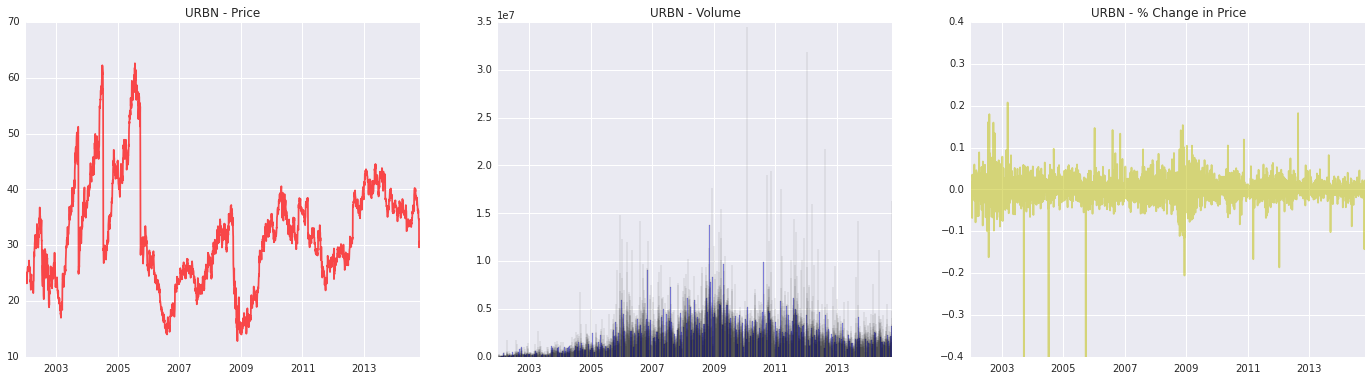

In [12]:
fig, axes = plt.subplots(1,3, figsize=(24,6))

axes[0].plot(example_price.index, example_price['price'], color='r', alpha=0.7)
axes[0].set_title('URBN - Price')
axes[1].bar(example_price.index, example_price['volume'], color='b', alpha=0.4)
axes[1].set_title('URBN - Volume')
axes[2].plot(example_price.index, example_price['%'], color='y', alpha=0.5)
axes[2].set_ylim(-.4,.4)
axes[2].set_title('URBN - % Change in Price')
plt.show()

#### Short Interest Data

We gathered total short sale shares (short interest) and total shares outstanding for each companies in S&P 500.  Short interest is typically reported by stock exchanges (i.e. NASDAQ, NYSE) twice a month per company.  

A typical data that many analyst use to analyze short interest is "Short as % of Float."  Floating shares refers to the total number of shares that trades in the market in a given period.  This number is different from total shares outstanding because some shares are owned by insiders and large block owners.  

Unfortunately, we faced difficulty in finding Floating shares data; therefore, we resorted to "Short as % of Shares Outstanding".  

In [13]:
example_si = pd.read_json(example['short_interest']).reindex(columns=['short_interest',
                                                                'shares_outstanding','short_over_shares_out'])
example_si.head()

,short_interest,shares_outstanding,short_over_shares_out
2003-12-15,2486367,39640000,0.062724
2004-01-15,2706969,39640000,0.068289
2004-02-13,2603553,39640000,0.065680
2004-03-15,1953317,39640000,0.049276
2004-04-15,2254448,39888000,0.056519


Short interest data was used only for defining Short Squeeze events.  Since this data defines our test variables, we had to forego using this data to make any predictions.

#### Historical Financial Statements

We gathered key financial statement items (i.e. Revenue, Operating Income, Net Income, EPS, Assets, Cash & Equivalent, and Equity) per each company every quarter up to 10 years.

In [36]:
example_financial = pd.read_json(example['historical_financial'])
example_financial['announce_date'] = pd.to_datetime(example_financial['announce_date'], unit='ms')
example_financial = example_financial.reindex(columns=['period', 'announce_date', 'revenue', 'operating_income', 'net_income',
                          'eps', 'assets', 'cash', 'equity'])
example_financial = example_financial.sort(columns='announce_date')
example_financial.head()

,period,announce_date,revenue,operating_income,net_income,eps,assets,cash,equity
0,2003Q3,2003-11-13,142.331,23.478,14.087,0.35,333.002,58.940,262.548
1,2003Q4,2004-03-11,176.123,31.067,18.429,0.45,359.595,87.173,290.130
2,2004Q1,2004-05-13,170.290,28.396,16.869,0.41,401.495,96.073,313.011
3,2004Q2,2004-08-12,189.484,34.120,20.508,0.25,433.158,102.286,337.944
4,2004Q3,2004-11-11,216.353,43.182,26.036,0.31,464.122,86.915,369.997


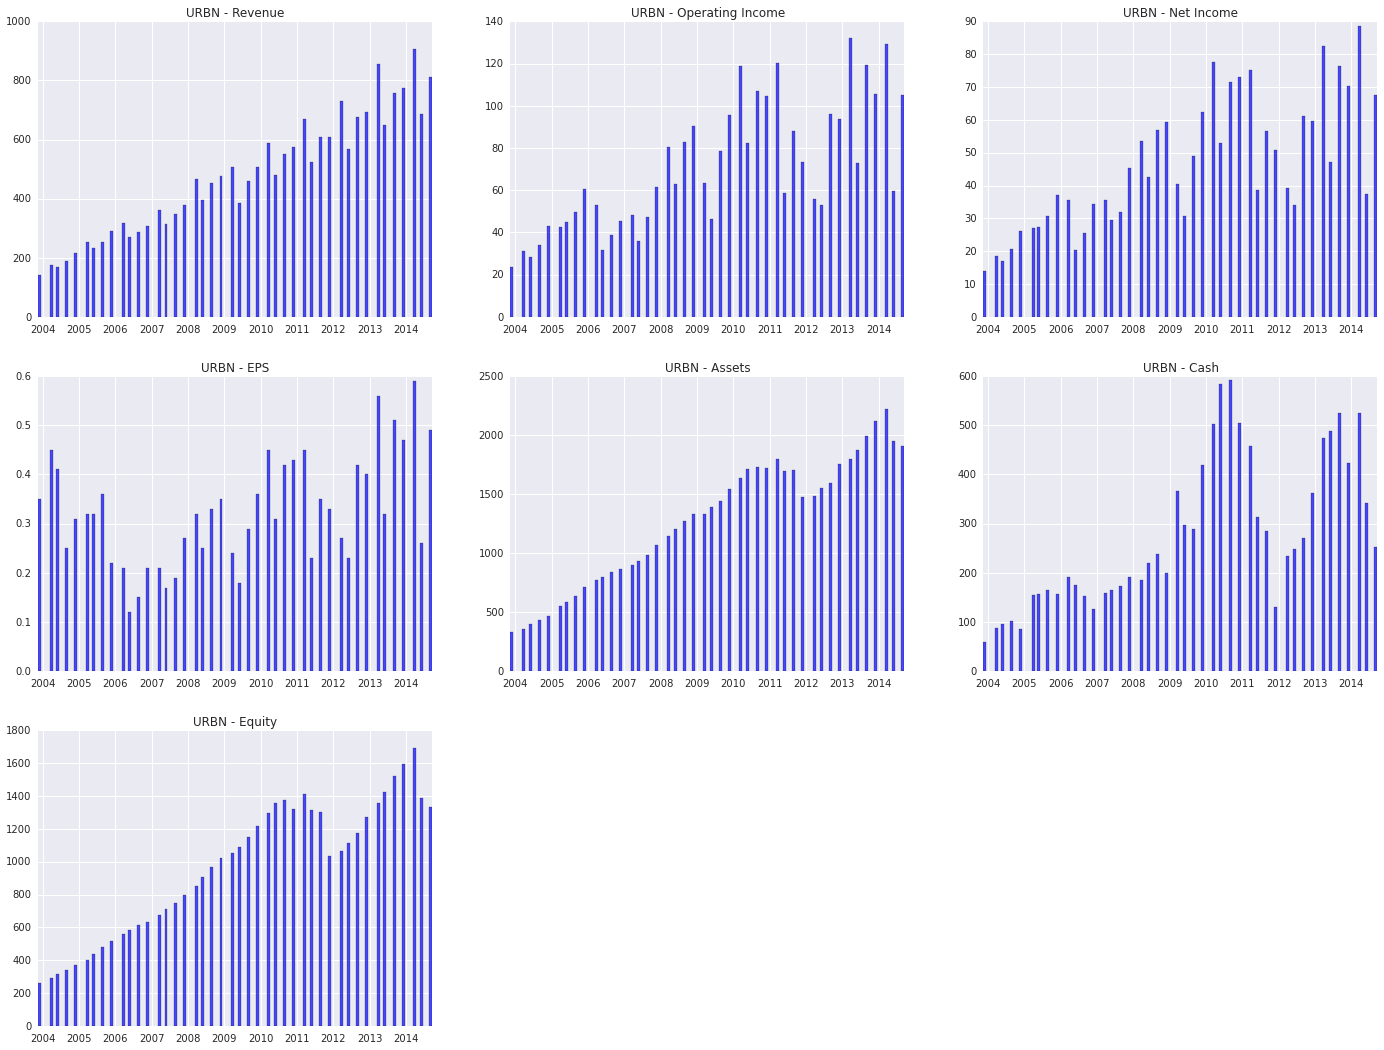

In [82]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(nrows=3, ncols=3, figsize=(24,18))

ax1.bar(example_financial.announce_date, example_financial.revenue, color='b', alpha=0.7, width=30.0)
ax1.set_title('URBN - Revenue')
ax2.bar(example_financial.announce_date, example_financial.operating_income, color='b', alpha=0.7, width=30.0)
ax2.set_title('URBN - Operating Income')
ax3.bar(example_financial.announce_date, example_financial.net_income, color='b', alpha=0.7, width=30.0)
ax3.set_title('URBN - Net Income')
ax4.bar(example_financial.announce_date, example_financial.eps, color='b', alpha=0.7, width=30.0)
ax4.set_title('URBN - EPS')
ax5.bar(example_financial.announce_date, example_financial.assets, color='b', alpha=0.7, width=30.0)
ax5.set_title('URBN - Assets')
ax6.bar(example_financial.announce_date, example_financial.cash, color='b', alpha=0.7, width=30.0)
ax6.set_title('URBN - Cash')
ax7.bar(example_financial.announce_date, example_financial.equity, color='b', alpha=0.7, width=30.0)
ax7.set_title('URBN - Equity')
fig.delaxes(ax8), fig.delaxes(ax9)
plt.show()

#### Analyst Estimates

For each of the companies, we collected EPS estimates made by the sell-side analysts per each period. 

In [95]:
example_analyst = pd.read_json(example['analyst_estimate'])
example_analyst['announce_date'] = pd.to_datetime(example_analyst['announce_date'], unit='ms')
example_analyst = example_analyst.reindex(columns=['estimator', 'analyst', 'announce_date', 'period', 
                                                   'estimates','eps_estimate', 'actual'])
example_analyst = example_analyst.sort_index(by='announce_date')
example_analyst.head()

,estimator,analyst,announce_date,period,estimates,eps_estimate,actual
28,210,89732,2003-12-04,20040131,Q,0.0875,0.1125
97,210,89732,2003-12-04,20040430,Q,0.0525,0.1025
0,210,89732,2003-12-04,20040131,A,0.2750,0.3000
1,39,73928,2003-12-09,20040131,A,0.2800,0.3000
29,39,73928,2003-12-09,20040131,Q,0.0950,0.1125


We estimated moving 1 month average of the EPS estimates by all of the analyst in a given date.  This is very similar to average of the polls that we worked on in our problem sets.  

In [398]:
def average_eps_estimate(company_price, company_analyst):
    """
    Returns pandas dataframe avg. eps estimate and PE ratio
    """
    avg_eps_estimates = list()

    for date in company_price.index:
        estimate_df = company_analyst[(company_analyst['announce_date'] <= date) & 
                                      (company_analyst['announce_date'] > date - np.timedelta64(1, 'M'))]

        avg_eps_est = estimate_df[estimate_df['estimates'] == 'A']['eps_estimate'].mean()

        avg_eps_estimates.append(avg_eps_est)
        
    avg_eps_estimate_series = pd.Series(avg_eps_estimates, index=company_price.index)    
    pe_ratio = company_price['price'] / avg_eps_estimate_series
    
    return pd.DataFrame({'price': company_price['price'], 'pe_ratio': pe_ratio, 
                         'avg_eps_est': avg_eps_estimate_series, '%': company_price['%']},
                        index=company_price.index)

In [400]:
mov_avg_eps = average_eps_estimate(example_price, example_analyst)
mov_avg_eps = mov_avg_eps[pd.notnull(mov_avg_eps['avg_eps_est'])]
mov_avg_eps = mov_avg_eps.reindex(columns=['price', '%', 'avg_eps_est', 'pe_ratio'])
mov_avg_eps.head()

,price,%,avg_eps_est,pe_ratio
2003-12-04,35.69,-0.065951,0.2750,129.781818
2003-12-05,36.02,0.009246,0.2750,130.981818
2003-12-08,36.61,0.016380,0.2750,133.127273
2003-12-09,36.49,-0.003278,0.2775,131.495495
2003-12-10,35.22,-0.034804,0.2775,126.918919


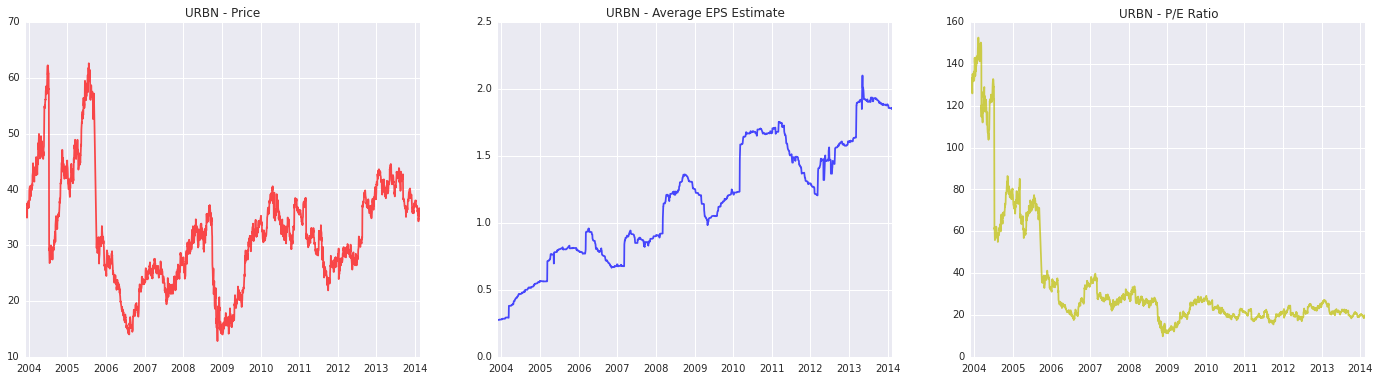

In [119]:
fig, axes = plt.subplots(1,3, figsize=(24,6))

axes[0].plot(mov_avg_eps.index, mov_avg_eps['price'], color='r', alpha=0.7)
axes[0].set_title('URBN - Price')
axes[1].plot(mov_avg_eps.index, mov_avg_eps['avg_eps_est'], color='b', alpha=0.7)
axes[1].set_title('URBN - Average EPS Estimate')
axes[2].plot(mov_avg_eps.index, mov_avg_eps['pe_ratio'], color='y', alpha=0.7)
axes[2].set_title('URBN - P/E Ratio')
plt.show()

#### Short Squeeze Phenomenons

Our "Y".  

Short Squeeze incident is not strictly defined in the finance industry. It's arbitraly defined as an incident when the share price jumps significantly (>5%) while there is significantly high short interest ratio (days-to-cover).  

Short interest ratio (days-to-cover) is commonly used metrics to measure the level of short sale shares.  It is calculated by

$$ Days \ to \ Cover = \frac {total \ short \ sale \ shares}{average \ (1 \ year) \ trading \ volume}$$

Because there is no official definition of short squeeze, we have decided to arbitrarly define short squeeze inciddent with the following  rule: 

1. share price increase > 5%
2. days-to-cover > 8 days

We recognize that this is not a strict definition of short squeeze, and not every one of our short squeeze incident can be attributed to short squeeze phenomenon.  

In [32]:
from pandas.tseries.offsets import DateOffset 

def define_short_squeeze(price_df, si_df, months):
    """
    Parameters: price_df - pandas DataFrame
                si_df - pandas DataFrame
                months - int
    
    Returns: short_squeeze - pandas Series
    """
    
    # Define average trading volume as that of rolling 1 year average
    avg_volumes = []
    for date in si_df.index:
        end = date
        start = date - DateOffset(months=months)

        avg_volumes.append(price_df[(price_df.index < end) & (price_df.index > start)]['volume'].values.mean().round())
    si_df['avg_volume'] = avg_volumes
    
    short_squeeze_df = pd.merge(price_df, si_df, left_index=True, right_index=True, how='outer').fillna(method='ffill')
    
    # Calculate the Days-to-Cover Ratio
    short_squeeze_df['days_to_cover'] = short_squeeze_df['short_interest'] / short_squeeze_df['avg_volume']
    
    # ***IMPORTANT*** 
    # Define Short Squeeze Phenomenon in which price jumped +5% in a day and Days-to-Cover Ratio is over 8
    short_squeeze_df['short_squeeze'] = (short_squeeze_df['%'] > 0.05) & (short_squeeze_df['days_to_cover'] > 8)
    
    return short_squeeze_df['short_squeeze'].astype(int)

In [37]:
# Example
# define_short_squeeze(example_price, example_si, 12)

We have already went through and determind Short Squeeze Incidents for individual companies.

In [378]:
example_short_sq = pd.read_json(example['short_squeeze'], typ='series')
example_short_sq[example_short_sq == 1]

2004-07-27    1
2004-09-10    1
2006-01-09    1
2008-07-16    1
2008-08-05    1
2008-08-08    1
2008-10-13    1
dtype: int64

## Data Exploration

By nature of our data coming from various sources, there wasn't a clear one-to-one relationship between the Short Squeeze ('Y') and other information besides Price and Volume data.  We had to go through extensive data munging to reformat the data to prepare it for machine learning methods.  Moreover, with a very large data set that contained more than 3 million rows of data, trying to find which variables may or may not relate to the Short Squeeze was intensely challenging.  

So, we began with the following question:  

##### Is there a relationship between Short Squeeze Incidents and Earnings Announcement Dates?

We felt that we can narrow down our observations to Short Squeeze incidents that happen on the day of or close to the day of the earnings announcements by the companies.  Intuitively, when a company releases the quarterly financial statements sometimes they contain information that positively surprises (also, negatively) the market.  For example, revenue might have increased by higher rate than historical trends or Earnings per Share (EPS) might have been significantly higher than estimates made by analysts in the market.  

Before we decided narrow down our observations, we wanted to verify if there is indeed Short Squeeze incidents occur more frequently on (or close to) the announcement dates for all of the companies.

In [120]:
company_iter = company_collec.find()

In [121]:
df_to_concat = []
# Iterate through the database for each company
for company in company_iter:
    ticker = company['ticker']
    
    # Obtain Historical Financial Data
    company_financial = pd.read_json(company['historical_financial'])
    company_financial['announce_date'] = pd.to_datetime(company_financial['announce_date'], unit='ms')
    
    # Obtain Short Squeeze Data and Isolate to those that contain 1 (or True)
    company_short_squeeze = pd.read_json(company['short_squeeze'], typ='series')
    company_short_squeeze = company_short_squeeze[company_short_squeeze == 1]
    
    # prepare to create DataFrame
    tickers = list()
    periods = list()
    announce_dates = list()
    from_announcements = list()
    
    for date in company_short_squeeze.index:
        tickers.append(ticker)

        # Finding the closest announcement date of financial statement from a short squeeze date
        days_from_announcement = company_financial['announce_date'] - date
        
        # Find the closest announcement both before and after the subject date
        positive_days = days_from_announcement[days_from_announcement > 0]
        negative_days = days_from_announcement[days_from_announcement < 0]

        positive_days.sort()
        negative_days.sort(ascending=False)

        # Select the closest announcement date either before or after the short squeeze incident
        if len(positive_days) is 0:
            days = int(negative_days.max()[0] / np.timedelta64(1, 'D'))
            from_announcements.append(days)

            periods.append(company_financial.ix[negative_days.index[0]]['period'])
            announce_dates.append(company_financial.ix[negative_days.index[0]]['announce_date'])

        elif (positive_days.min()[0]) < (negative_days.abs().min()[0]): 
            days = int(positive_days.min()[0] / np.timedelta64(1, 'D'))
            from_announcements.append(days)

            periods.append(company_financial.ix[positive_days.index[0]]['period'])
            announce_dates.append(company_financial.ix[positive_days.index[0]]['announce_date'])

        else: 
            days = int(negative_days.max()[0] / np.timedelta64(1, 'D'))
            from_announcements.append(days)
            periods.append(company_financial.ix[negative_days.index[0]]['period'])
            announce_dates.append(company_financial.ix[negative_days.index[0]]['announce_date'])

    company_df2 = pd.DataFrame({'ticker': tickers, 'short_squeeze_dates': company_short_squeeze.index, 
                                'period': periods, 'announce_date': announce_dates, 'from_announcement': from_announcements})
        
    df_to_concat.append(company_df2)
    
short_sq_from_announcement_df = pd.concat(df_to_concat)

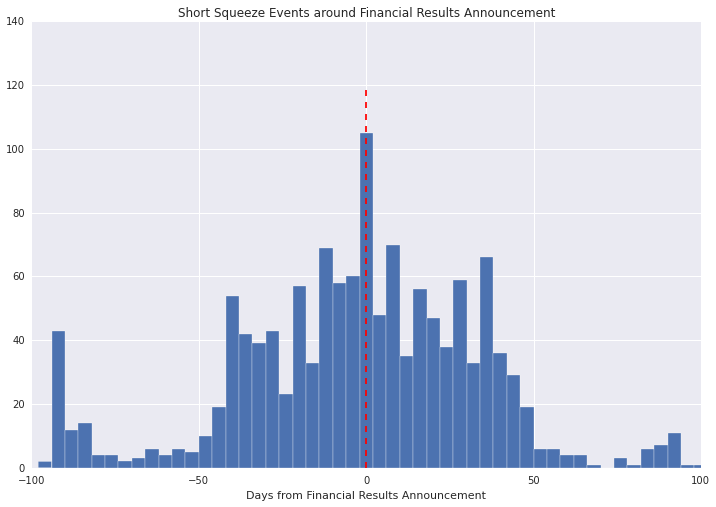

In [134]:
short_sq_from_announcement_df['from_announcement'].hist(bins=50, figsize=(12,8), edgecolor='w')
plt.vlines(0, 0, 120, color='r', linestyle='dashed')
plt.xlim(-100,100)
plt.title('Short Squeeze Events around Financial Results Announcement')
plt.xlabel('Days from Financial Results Announcement')
plt.show()

We could see that the Short Squeeze incidents were relatively normally distributed around the earninings announcement date, with clear exception of day zero - plus or minus approximately 4 days.  Our intuition was likely correct in that these short squeeze opportunities happen as a result of new positive information released by the companies. 

We decided to focus our observations on those Short Squeeze events that happens closely around the earnings announcement dates.  

#### What factors in the Earnings (Financial Statements) Annoucements impact Short Squeeze Incidents?

Once we made the decision to focus on the Short Squeeze incidents near the earnings announcement dates, we wanted to explore what news in the financial statements were most impacting the share prices positively.  

In [178]:
company_iter = company_collec.find()

In [179]:
df_to_concat = list()
# Iterate through the database for each company
for company in company_iter:
    ticker = company['ticker']

    company_short_squeeze = pd.read_json(company['short_squeeze'], typ='series')
    company_short_squeeze = company_short_squeeze[company_short_squeeze == 1]

    if len(company_short_squeeze) == 0:
        continue 

    # Historical Financial Statements
    company_financial = pd.read_json(company['historical_financial'])
    company_financial['announce_date'] = pd.to_datetime(company_financial['announce_date'], unit='ms')
    company_financial = company_financial.reindex(columns=['period', 'announce_date', 'revenue', 'operating_income', 'net_income',
                                                           'eps', 'assets', 'cash', 'equity'])
    company_financial = company_financial.sort(columns='announce_date')


    # Create DataFrame of Percentage Change in Financial Statement Items
    company_financial = company_financial[pd.notnull(company_financial['announce_date'])]
    for i in range(2,9):
        item = company_financial.columns[[i]].values[0]
        company_financial[item+'_%_chg'] = company_financial[item].pct_change()
    company_fin_change = company_financial.drop(company_financial.columns[range(2,9)], 1)
    company_fin_change = company_fin_change[(pd.notnull(company_fin_change['revenue_%_chg'])) & 
                                            (pd.notnull(company_fin_change['operating_income_%_chg']))]

    # Determine whether Announcement Date has Short Squeeze Event
    short_squeeze_follow_announcement = list()
    for date in company_fin_change['announce_date']:
        short_squeeze_events = company_short_squeeze[(company_short_squeeze.index <= date + np.timedelta64(5,'D')) & 
                                           (company_short_squeeze.index >= date - np.timedelta64(5,'D'))]
        if len(short_squeeze_events) == 0: 
            short_squeeze_follow_announcement.append(0)
        else:
            short_squeeze_follow_announcement.append(1)

    company_fin_change['short_squeeze'] = short_squeeze_follow_announcement
    
    df_to_concat.append(company_fin_change)

financial_result_impact = pd.concat(df_to_concat)

In [181]:
# Clear NaN and Inf
financial_result_impact = financial_result_impact.replace([np.inf, -np.inf], np.nan)
financial_result_impact = financial_result_impact.dropna()
financial_result_impact.head()

,period,announce_date,revenue_%_chg,operating_income_%_chg,net_income_%_chg,eps_%_chg,assets_%_chg,cash_%_chg,equity_%_chg,short_squeeze
1,2003Q4,2004-01-29,0.048828,-0.060800,0.052770,0.048780,0.006566,-0.022605,0.073080,0
2,2004Q1,2004-04-27,0.103689,0.337308,0.203008,0.162791,0.052103,-0.497543,0.098488,0
3,2004Q2,2004-07-29,0.185979,0.777070,0.877083,0.860000,0.080392,1.521289,0.088901,0
4,2004Q3,2004-10-28,-0.105082,-0.288172,-0.190899,-0.193548,0.026154,0.125285,0.058641,0
5,2004Q4,2005-01-27,0.047597,-0.160121,-0.193416,-0.213333,0.034365,0.013588,0.022086,0


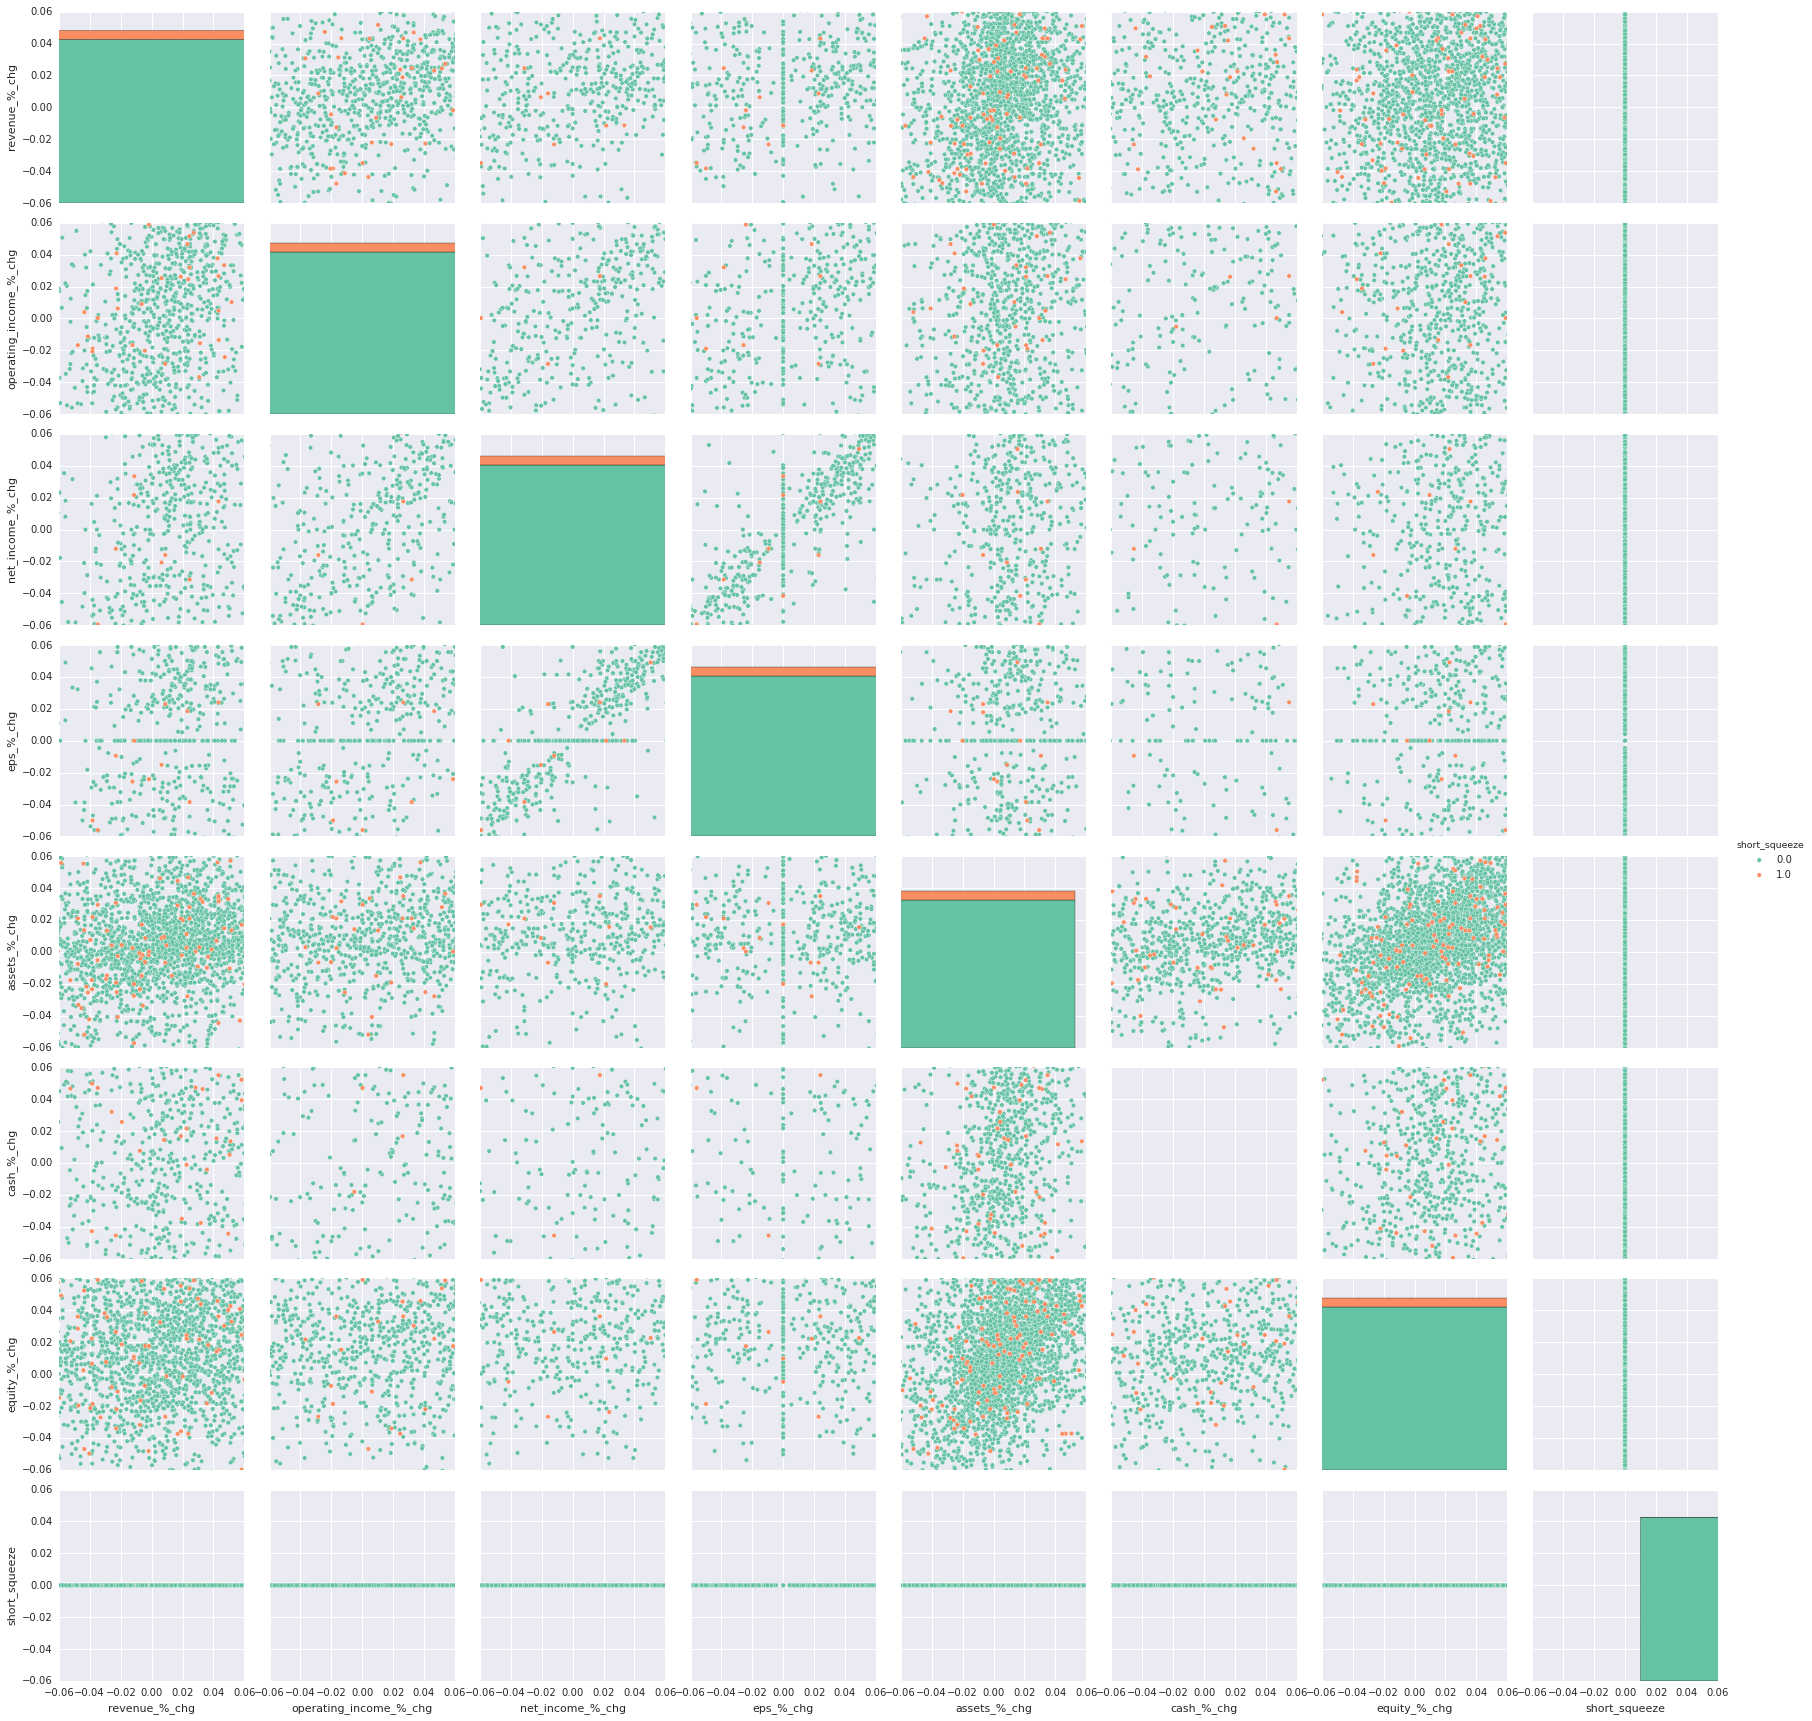

In [193]:
axis_grid = sns.pairplot(financial_result_impact[financial_result_impact.columns[2:10]], hue='short_squeeze', palette='Set2')
plt.show()

Unfortunately, there was no visibly noticeable differences in financial results of those that resulted in Short Squeeze incident versus those that did not.  

We quickly looked at Singular Value Decomposition using sklearn module TruncatedSVD.

In [237]:
from sklearn.decomposition import PCA

X = financial_result_impact[financial_result_impact.columns[2:9]].as_matrix()
Y = financial_result_impact[financial_result_impact.columns[9]].as_matrix()

svd = sklearn.decomposition.TruncatedSVD(n_components=2)

X_centered = X - np.mean(X, axis=0)
X_2d = svd.fit_transform(X_centered)

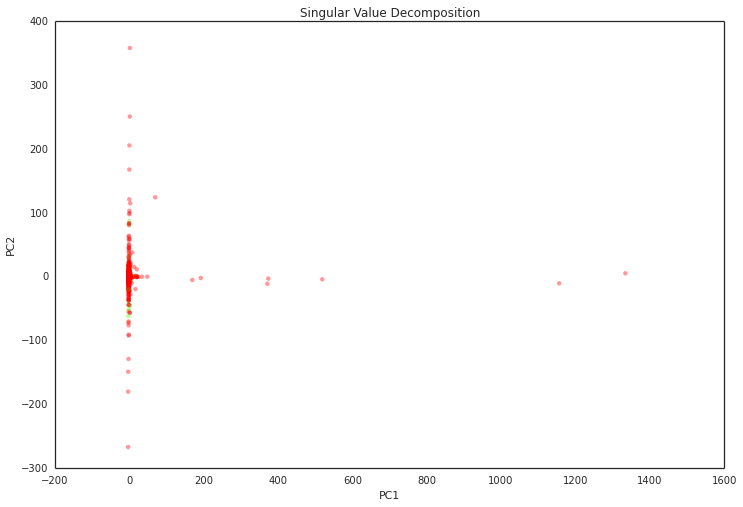

In [238]:
fig = plt.figure(figsize=(12,8)); ax = fig.add_subplot(1,1,1)

ax.scatter(X_2d[:,0], X_2d[:,1], c=Y, s = 20, cmap=plt.cm.prism, alpha=0.4, linewidth=0)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Singular Value Decomposition')
plt.show()

Unfortunately, PC1 and PC2 did not yield a noticeable differences between Short Squeeze events and nones.  

#### What factors in Analyst Estimates and Valuation impact Short Squeeze Incidents?

We turned our attention to Analyst Earnings Estimate and Valuations. 

For simplicity, we narrowed the Analyst Earnings estimate to EPS for the next fiscal year.  For valuation, we decided to narrow our focus to the popular P/E ratio using the Analyst Earnings estimate.  

In [444]:
company_iter = company_collec.find()

In [ ]:
announcement_df = []
# Iterate through the database for each company
for company in company_iter:
    ticker = company['ticker']
    
    if company['analyst_estimate'] == '{}':
        continue
    
    company_short_squeeze = pd.read_json(company['short_squeeze'], typ='series')

    # Price & Volume Data
    company_price = pd.read_json(company['price'])

    # Historical Financial Data
    company_financial = pd.read_json(company['historical_financial'])
    company_financial['announce_date'] = pd.to_datetime(example_financial['announce_date'], unit='ms')
    company_announce_dates = company_financial['announce_date'].sort_index()

    # Analyst Estimates Data
    company_analyst = pd.read_json(company['analyst_estimate'])
    company_analyst['announce_date'] = pd.to_datetime(company_analyst['announce_date'], unit='ms')
    company_analyst = company_analyst.sort_index(by='announce_date')

    # Use average_eps_estimate function defined above to generate a DataFrame containining
    # Price, Avg. EPS Estimate, and PE Ratio
    avg_eps_and_pe_ratio = average_eps_estimate(company_price, company_analyst)
    avg_eps_and_pe_ratio['short_squeeze'] = company_short_squeeze
    avg_eps_and_pe_ratio = avg_eps_and_pe_ratio[pd.notnull(avg_eps_and_pe_ratio['avg_eps_est'])]

    # Select 35 Days (+5 Days and -30 Days) around Announcement Date
    for date in company_announce_dates:
        df_index_reset = avg_eps_and_pe_ratio.sort(ascending=True).copy()
        df_index_reset = df_index_reset.reset_index()
        if not df_index_reset['index'].isin([date]).any():
            continue
        day_zero = df_index_reset[df_index_reset['index'] == date].index[0]
        result = df_index_reset.ix[day_zero-29: day_zero+5]
        # Adjust for some DF that do not have full 35 days
        if len(result) < 35:
            add_row = 35 - len(result)
            a = np.empty(add_row)
            a[:] = np.nan
            result = result.append(pd.DataFrame({'index':a, 'avg_eps_est': a, 'pe_ratio':a,'price':a},
                                                index=result.index[0]-range(add_row)-1))
        result.sort_index(inplace=True)
        result['index'] = range(-30, 5, 1)

    print ticker
    announcement_df.append(result)

In [514]:
price_series = [announcement['price'].values for announcement in announcement_df]
pe_series = [announcement['pe_ratio'].values for announcement in announcement_df]
price_chg_series = [announcement['%'].values for announcement in announcement_df]
avg_eps_series = [announcement['avg_eps_est'].values for announcement in announcement_df]

# Clean Up for NA and Normalize the data for Price and Average EPS
price_series = [(item-item.mean())/(item.max()-item.min()) for item in price_series if pd.notnull(item).all()]
avg_eps_series = [(item-item.mean())/(item.max()-item.min()) for item in avg_eps_series if pd.notnull(item).all()]
pe_series = [item for item in pe_series if pd.notnull(item).all()]
price_chg_series = [item for item in price_chg_series if pd.notnull(item).all()]

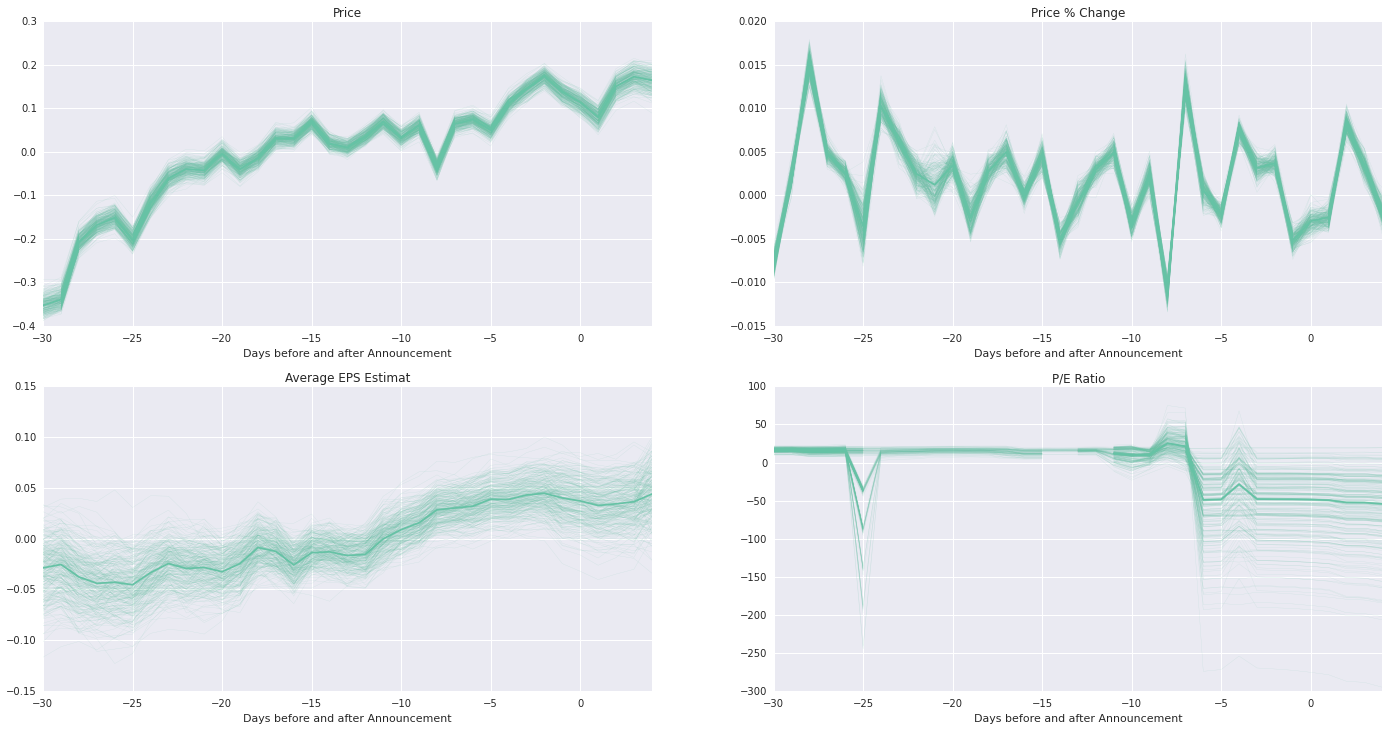

In [515]:
sns.set(style="darkgrid", palette="Set2")
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(24,12))

ax1 = sns.tsplot(price_series, time=range(-30,5,1), ax=ax1,err_style="boot_traces", n_boot=300)
ax1.set_title('Price')
ax1.set_xlabel('Days before and after Announcement')
ax2 = sns.tsplot(price_chg_series, time=range(-30,5,1), ax=ax2,err_style="boot_traces", n_boot=300)
ax2.set_title('Price % Change')
ax2.set_xlabel('Days before and after Announcement')
ax3 = sns.tsplot(avg_eps_series, time=range(-30,5,1), ax=ax3,err_style="boot_traces", n_boot=300)
ax3.set_title('Average EPS Estimat')
ax3.set_xlabel('Days before and after Announcement')
ax4 = sns.tsplot(pe_series, time=range(-30,5,1), ax=ax4,err_style="boot_traces", n_boot=300)
ax4.set_title('P/E Ratio')
ax4.set_xlabel('Days before and after Announcement')
plt.show()

Interestingly, we find overall increase in share prices before the announcement date.  In addition, we also find increase in Average EPS estimate.  Even though we have not determined which variables are related to Short Squeeze events, we forge ahead to apply this data to machine learning algorithm.

## Hidden Markov Model

For this project, we took this opportunity to explore a machine learning technique that was not taught in the course.

We considered many models including RandomForest; however, due to the sequential nature of our data, we felt that Hidden Markov Model is the most appropriate model for this project. 

For those who are not familiar with HMM, please take a look at the link below:

http://en.wikipedia.org/wiki/Hidden_Markov_model

Unfortunately, we found out that sklearn was deprecating HMM from the library was no longer being maintained.  We sought various options but found seqlearn, which is a supervised HMM learning module that has been modeled after sklearn.  

Most of the methods such as fit() and predict() were similar to learning methods found in sklearn such as RandomForest.

Please take a look the documentation for further details about this library:

https://github.com/larsmans/seqlearn

In [533]:
import seqlearn 
from seqlearn.hmm import MultinomialHMM
from seqlearn.perceptron import StructuredPerceptron
from seqlearn.evaluation import SequenceKFold, whole_sequence_accuracy

In [551]:
# Build X and Y by separating out Short_Squeeze column
# Eliminate NA and keep count of total lengths
lengths = list()
cleaned_dfs = list()
for announcement in announcement_df:
    cleaned_df = announcement.replace([np.inf, -np.inf], np.nan).dropna()
    lengths.append(len(cleaned_df))
    cleaned_dfs.append(cleaned_df)

outcome_df = pd.concat(cleaned_dfs)

In [552]:
outcome_df.head()

,%,avg_eps_est,index,pe_ratio,price,short_squeeze
37,0.007279,0.284286,-30,141.160804,40.13,0
38,0.008971,0.284286,-29,142.427136,40.49,0
39,-0.004693,0.284286,-28,141.758794,40.30,0
40,0.015881,0.284286,-27,144.010050,40.94,0
41,-0.008305,0.284286,-26,142.814070,40.60,0


In [553]:
X = outcome_df.as_matrix(['%','avg_eps_est','pe_ratio','price'])
Y = outcome_df.as_matrix(['short_squeeze'])

We will be using seqlearn's SequenceKFold to split up this matrix into a subgroup of 35 sequences.  Each instance will have matching corresponding length to keep track of the sequences.  We will stick with the standard 10-folds.

In [572]:
kfold = SequenceKFold(lengths, n_folds=10, n_iter=1)

In [574]:
structure_perceptron_scores = list()
multinomial_hmm_scores = list()

for train_index, train_lengths, test_index, test_lengths in list(kfold):
    X_train, Y_train, X_test, Y_test = X[train_index], Y[train_index], X[test_index], Y[test_index]
    
    # Instantiate and Train Multinomial HMM
    clf1 = MultinomialHMM()
    clf1.fit(X_train,Y_train, train_lengths)

    # Instantiate and Train Structural Perceptron
    clf2 = StructuredPerceptron()
    clf2.fit(X_train, Y_train, train_lengths)
    
    Y_pred1 = clf1.predict(X_test, test_lengths)
    Y_pred2 = clf2.predict(X_test, test_lengths)
    
    hmm_score = whole_sequence_accuracy(Y_test, Y_pred1, test_lengths)
    perceptron_score = whole_sequence_accuracy(Y_test, Y_pred2, test_lengths)

    multinomial_hmm_scores.append(hmm_score)
    structure_perceptron_scores.append(perceptron_score)
    

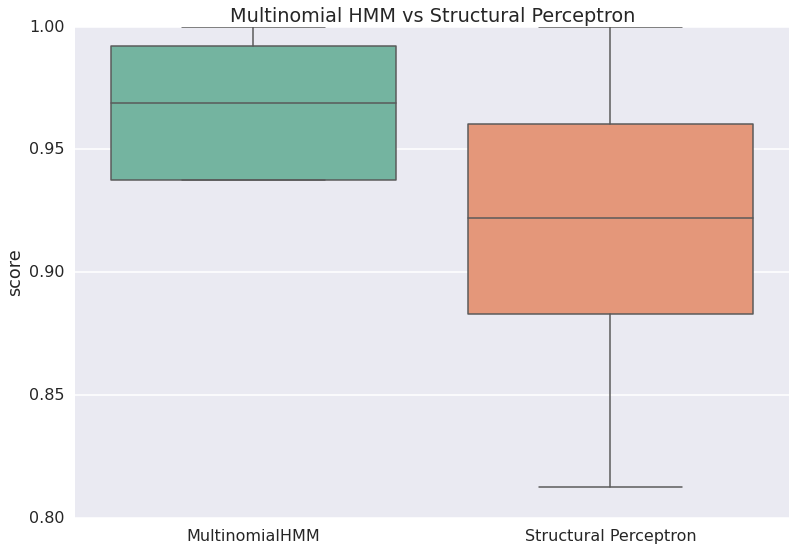

In [578]:
sns.boxplot([multinomial_hmm_scores, structure_perceptron_scores], names=['MultinomialHMM', 
                                                                          'Structured Perceptron'])
plt.title("Multinomial HMM vs Structured Perceptron")
plt.ylabel("score")
plt.show()

While the scores of both Multinomial HMM and Structured Perceptron appear quite high; in reality, as was demonstrated in problem set 5, with overwhelming days of no-Short Squeeze Events, if we had predicted all '0's, we would have scored quite high as well.  

In fact, upon further investigation, we found out that Multinomial HMM never made a single prediction for '1'; despite the result, it attain higher average score than the Structured Perceptron.  On the other hand, Structured Perceptron did make predictions of '1''s and still managed to score approximately over 90 percentile.  We believe Structured Perceptron yields superior results.  

With this result, we decided to test one of Structured Perceptron's parameters - maximum iteration, which is the number of times each sequence is used for prediction. 

In [591]:
param_scores = list()
for i in range(1,30):
    structure_perceptron_scores = list()
    for train_index, train_lengths, test_index, test_lengths in list(kfold):
        X_train, Y_train, X_test, Y_test = X[train_index], Y[train_index], X[test_index], Y[test_index]

        # Instantiate and Train Structural Perceptron
        clf = StructuredPerceptron(max_iter=i)
        clf.fit(X_train, Y_train, train_lengths)

        Y_pred = clf.predict(X_test, test_lengths)

        perceptron_score = whole_sequence_accuracy(Y_test, Y_pred, test_lengths)

        structure_perceptron_scores.append(perceptron_score)
    
    param_scores.append(structure_perceptron_scores)


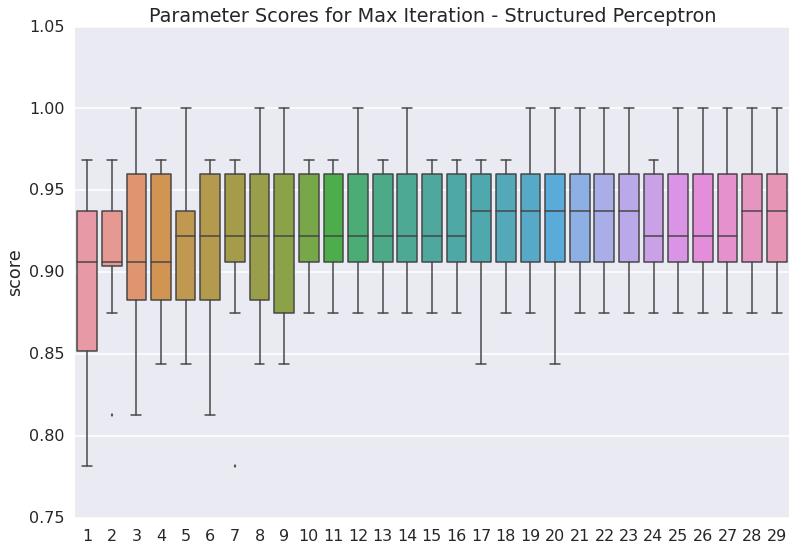

In [592]:
sns.boxplot(param_scores, names=range(1,30))
plt.title("Parameter Scores for Max Iteration - Structured Perceptron")
plt.ylabel("score")
plt.show()

The boxplot shows that there may be a modest improvement in prediction score as Max Iteration increases; however, the score leveled off after the parameter reached around 10.

## Conclusion

In our Final Project, we attempted to predict short squeeze trading opportunities by attempting to predict ahead of short squeeze events.  We looked at various data including price, % change in price, P/E ratio, Average EPS estimates, various historical financial items.  

We experimented with Singular Value Decomposition in the process in an effort to find variables that can help us predict short squeeze events.  

We explored new machine learning technique - Hidden Markov Model, which was not taught in class and is not included in sklearn library anymore.  We used seqlearn library, and experimented with Multinomial HMM and Structured Perceptron, which are both solved by Viterbi algorithms.  

We discovered that Structured Perceptron, although scored lower, is a superior method for Hidden Markov Model in this particular case.  We also explored maximum iteration parameter for Structured Perceptron and realized that after around 10 prediction scores do not rise significantly. 

While we can't claim to have found a method to perfectly predit Short Squeeze Events in the market (if so, we would be in position to make a lot of money!), we believe Structured Perceptron method is an interesting machine learning method for sequential data such as stock price movements.  We believe there is a lot of room for further exploration with Structured Perceptron method, and it's quite unfortunately that sklearn will be dropping Hidden Markov Models from its modules.

#### Future Considerations

We have several other consideration that caught our interest while working on this project.  

Initially, we had gathered up Ownership Data from WRDS for each individual company going back 10 years; unfortunatetly, the size of the data was so exhaustive that iPython notebook crashed a several time as we were loading the data.  Later on, we were able to successful load all of the data, including the Ownership data, into MongoDB; however, we decided for forego analyzing the Ownership data given the limited time that we had for this project.  We think Ownership data can be an interesting data set to look into in the future.   

We also considered replicating the exercises that we did for problem set 4 using analyst estimates.  Similar to the analysis of the polls in problem set 4, we wanted to find a way to correctly predict EPS results by averaging the EPS predictions of each individual analysts.  We believe this could be an interesting area to explore in the future as well.  